## Front Matter
I want the Notebook to be as informative as possible, but model creating and training process follows some standard procedure that I do not want to repeat. Therefore, if you can, spend time reading the `PROLOGUE/Routine.ipynb` Notebook first.

# Paper Implementation - VGG16
Hello, this is my first milestone project - implementation of the VGG16 architecture from the paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556). The paper explored the effect of increasing layers on a model based on the filter size of $3*3$ that we previously explored in the `TinyCNN` notebook (that is also the reason why that architecture is called TinyVGG). The architecture was the runner-up in the ImageNet 2014 Challenge for classification.

16 in VGG16 stands for 16 layers, all based on two basic units: convolution with filter size $3*3$, stride $1$, padding $1$ and max-pooling with window size $2*2$, stride $2$. The table shown below, taken from the paper abovem, is the architecture for each of the VGG configuration. In this project, I will implement the VGG16-D one.

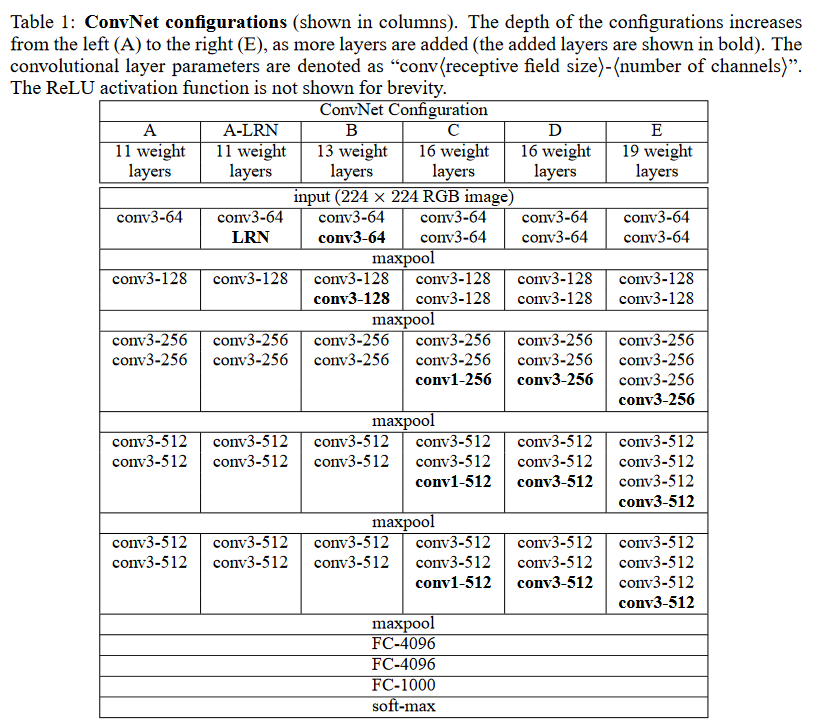

I divide the project into two notebooks. This is the first one, where I will focus on acquiring and transforming the data. The next one will be about building and training the model.

In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 7.3 MB/s 


In [2]:
!pip install --upgrade mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.9 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


## 1. Downloading and extracting data
The task for our model will be classification, using a bigger dataset called [Food101](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html). This is a built-in PyTorch dataset, so the processing can be fairly straightforward. However, it is not fun, so let's take the [Kaggle version](https://www.kaggle.com/datasets/kmader/food41) and process it to what we want.

First, downloading data from Kaggle. The easy way: you can download the zip file (~6 GB), upload it to Google Drive, and then mount Google Drive to Colab. The slightly harder approach: you will need to sign up and obtain a Kaggle token, and then use the `kaggle` module to download the data. Let's do that.

First, we need a variable to keep track of the environment we are in as it is different to run the notebook right on Kaggle and run it anywhere else (from the teaching of a Kaggle Grandmaster)

In [3]:
# Import modules
import os
from pathlib import Path

# Keep an environment variable
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

Next, based on the [docs](https://github.com/Kaggle/kaggle-api), we will need to create a `/.kaggle/kaggle.json`. You can go to File Explorer and create a folder in your machine, or we can create that file right from the notebook. Let's do that.

In [4]:
creds = '{"username":"hangenyuu","key":"a5ca93ee60c444e1e8527145caa7b86a"}'

In [5]:
# Paste your API here (I have run and then deleted mine)
# creds = ''

In [6]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Next, let's use the method `dataset_download_cli` to download and unzip data files.

In [7]:
# Sanity check
!kaggle datasets list

ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                 5MB  2022-11-13 15:47:17          13907        396  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india    Credit Card Spending Habits in India           319KB  2022-12-14 07:30:37           1046         43  1.0              
michals22/coffee-dataset                                        Coffee dataset                                  24KB  2022-12-15 20:02:12           3178         75  1.0              
thedevastator/unlock-profits-with-e-commerce-sales-data         E-Commerce Sales Data

In [8]:
path = Path('kmader/food41')

In [9]:
if not iskaggle and not path.exists():
    import kaggle
    kaggle.api.dataset_download_cli(str(path))

100%|██████████| 5.30G/5.30G [00:40<00:00, 142MB/s]

We have the data in the zip file. Now all we need to do is to extract them out.

In [10]:
folder_path = Path('food41')
os.mkdir(folder_path)

In [11]:
import zipfile
zipfile.ZipFile(f'{folder_path}.zip').extractall(folder_path)

### Food-101
The dataset is introduced in this [paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/ttps://), consisting of 101 classes, each with 750 training and 250 testing examples, totalling 1000 images each. The dataset comes with a metadata folder, giving information about which image should go into which subset, which is great! The data was already split into traing and testing examples, but we also need a *validation set*. The testing examples were manually selected to contain noise and challenge the model, so we will not touch that, but we will split the training set further to create a validation set. Now, creating a good validation set is [an art](https://www.fast.ai/posts/2017-11-13-validation-sets.html), but here we will jsut use good ol' random splitting.

First, we will need to format the in the `images` folder into `train`, `valid`, and `test` folders. Next, we will load the data. The process is quite the same, what's new this time is we will apply more transformation.

In [20]:
# Generic torch process
from torch import nn
import torch
from torch.utils.data import DataLoader

# Specifically for computer vision
import torchvision
from torchvision import datasets, transforms, models

# For post-training process
from torchmetrics import ConfusionMatrix, Accuracy #Among others
from mlxtend.plotting import plot_confusion_matrix #Among others

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Other module(s)
import matplotlib.pyplot as plt
import gc
import json
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import requests

In [13]:
np.random.seed(17)
torch.manual_seed(17)

In [14]:
with open('/content/food41/meta/meta/train.json', 'r') as fp:
    train_dict = json.load(fp)
with open('/content/food41/meta/meta/test.json', 'r') as fp:
    test_dict = json.load(fp)
print(len(train_dict['apple_pie']), train_dict['apple_pie'][-10:])
print(len(test_dict['apple_pie']), test_dict['apple_pie'][-10:])

750 ['apple_pie/960233', 'apple_pie/960669', 'apple_pie/962315', 'apple_pie/966595', 'apple_pie/973088', 'apple_pie/973428', 'apple_pie/98352', 'apple_pie/98449', 'apple_pie/987860', 'apple_pie/997124']
250 ['apple_pie/885848', 'apple_pie/886793', 'apple_pie/904832', 'apple_pie/908367', 'apple_pie/963140', 'apple_pie/981895', 'apple_pie/984571', 'apple_pie/986844', 'apple_pie/99556', 'apple_pie/997950']


As mentioned, there are 1000 images for 101 categories of food. Each .json file is essentially a dictionary containing 101 keys and 101 values, each value is a list of paths of 750 training images or 250 testing images.

The list value of a dictionary key contains the strings that are the file paths of the images without the extension. We will note this while using it to copy the images to proper folders.

In [15]:
if not os.path.exists('data'):
    os.mkdir('data')
new_data_path = Path('data')
original_data_path = Path('food41/images')
new_folders = ['train', 'test']
for folder in new_folders:
    if not os.path.exists(new_data_path/folder):
        os.mkdir(new_data_path/folder)
    if folder == 'train':
        if not os.path.exists(new_data_path/'valid'):
            os.mkdir(new_data_path/'valid')
        for key, value in train_dict.items():
            train_value, valid_value = train_test_split(value, train_size=0.75)
            train_set, valid_set = set(train_value), set(valid_value)
            if not os.path.exists(new_data_path/folder/key):
                os.mkdir(new_data_path/folder/key)
            if not os.path.exists(new_data_path/'valid'/key):
                os.mkdir(new_data_path/'valid'/key)
            for image in os.listdir(original_data_path/key):
                image_path = key + '/' + image
                image_path = image_path.split('.')[0]
                if image_path in train_set:
                    shutil.copy(original_data_path/key/image, new_data_path/'train'/key/image)
                if image_path in valid_set:
                    shutil.copy(original_data_path/key/image, new_data_path/'valid'/key/image)
    else:
        for key, value in test_dict.items():
            value_set = set(value)
            if not os.path.exists(new_data_path/folder/key):
                os.mkdir(new_data_path/folder/key)
            for image in os.listdir(original_data_path/key):
                image_path = key + '/' + image
                image_path = image_path.split('.')[0]
                if image_path in value_set:
                    shutil.copy(original_data_path/key/image, new_data_path/folder/key/image)

And we are done! Now we can load data as we like!

But first, let's write some transformations for the images to perform data augmentation.

### Data Augmentation
This is a technique to generate more training data by performing operations on the original data (such as flipping, shearing, rotating for images). The artificial data should generate the same output as the original one, but they are different, so hopefully the model is encouraged to learn the general pattern of the data instead of overfitting. Data augmentation is usually seen in training, but there is a technique called "test-time augmentation" that has been passed down among the Kaggle Grandmaster and implemented in the library [fastai](https://docs.fast.ai/learner.html#tta).

For the transformations, first we have the staples: `ToTensor()`, which turns images to `torch.tensor` objects. You may notice the `Normalize()` with some arbitrary parameters (the first is a list of means for each color channel and the second is a list of standard deviations for each color channel). These are parameters for the normalization of [ImageNet](https://image-net.org/index.php) dataset and are required by all PyTorch pre-trained models. This may not necessarily be true for our data, but it can be used. PyTorch also recommends having images of size $224*224$ pixels, so we use resize to that. The other transformations do what it is called for, with parameters for angle, probability, etc. (Explore more transformations on PyTorch [docs](https://pytorch.org/vision/stable/transforms.html).) Finally, we call `Compose()` to stack these transformations together.



In [16]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(35),
                                      transforms.RandomVerticalFlip(0.27),
                                      transforms.RandomHorizontalFlip(0.27),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_n_test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

To load the data, the generally workflow is: data &rarr; `datasets` object to transform &rarr; `DataLoader` object to feed to model. Here we will use the class `ImageFolder` to load the dataset from folder. The [docs](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) species file that the file should be arranged in the sequence
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/[...]/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/[...]/asd932_.png
```
which exactly what I have done above.

In [17]:
data_dir = Path('data')
train_dir = data_dir/'train'
valid_dir = data_dir/'valid'
test_dir = data_dir/'test'

In [40]:
train_dataset = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform = valid_n_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform = valid_n_test_transforms)

print(train_dataset)
print(valid_dataset)
print(test_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

Dataset ImageFolder
    Number of datapoints: 56762
    Root location: data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomRotation(degrees=[-35.0, 35.0], interpolation=nearest, expand=False, fill=0)
               RandomVerticalFlip(p=0.27)
               RandomHorizontalFlip(p=0.27)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 18988
    Root location: data/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 25250
    Root location: data/test
    StandardTransform
T

Now let's define a function to visualize the image from the DataLoader to make sure that we do everything right. One quirk of PyTorch is that the pixel in an image are arranged (color channels, width, height) while matplotlib expects it to be (width, height, color channels) so we will need to move data around with `permute((1,2,0))`. We also need to undo the normalization we have done above, and clipping the pixel values to remove noise.

In [21]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/HangenYuu/vision_learner/main/ARCHITECTURE/CNN/Paper/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import imshow

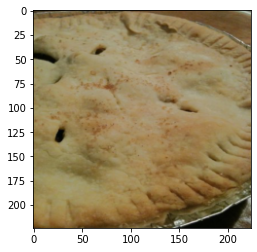

In [22]:
# A test image
imshow(next(iter(test_loader))[0][1]);

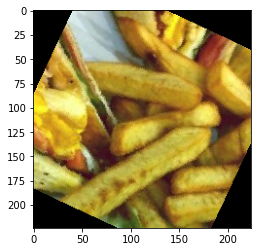

In [23]:
# A training image
imshow(next(iter(train_loader))[0][1]);
# Look at the rotation from data augmentation!

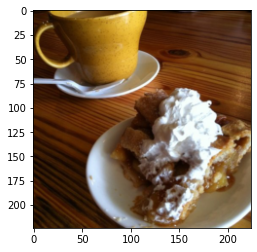

In [24]:
# A validation image
imshow(next(iter(valid_loader))[0][1]);

In [25]:
class_names = train_dataset.classes
class_names[-10:]

['spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']

That's basically it for this notebook! Now let's move on to the next part, where we will create a model and start training!

## 2. Creating models
The first model that we create will be a model from scratch. I borrowed the idea for a general implementation of all VGG architectures from [Aladdin Persson](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_vgg_implementation.py)

In [26]:
VGG_TYPES = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "VGG19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}

In [27]:
class VGG_net(nn.Module):
    def __init__(self, in_channels=3, out_classess=101, vgg_type="VGG16"):
        super().__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_TYPES[vgg_type])
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 4096), # The 7*7 from the previous pooling layer
            nn.ReLU(), # I do not do it in place
            nn.Dropout(p=0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, out_classess)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x
    
    def create_conv_layers(self, arch):
        # Stack the layers into a list before passing to nn.Sequential
        layers = []
        in_channels = self.in_channels

        for layer in arch:
            if type(layer) == int:
                out_channels = layer

                layers.extend(
                    [nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1),
                     nn.BatchNorm2d(layer), # Invented after the original paper, but improve performance
                     nn.ReLU()
                     ]
                    
                )
                in_channels = layer
                # Number of output in the last layer is the number
                # of inputs for the next layer
            elif layer=='M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        return nn.Sequential(*layers)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [31]:
model1 = VGG_net().to(device)
model1

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.02)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [33]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               metric: Accuracy,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss & accuracy
        loss = criterion(y_pred, y)
        train_loss += loss
        train_acc += metric(y_pred.argmax(dim=1), y)

        # 3. Empty out gradient
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimize 1 step
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")

In [34]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               metric: Accuracy,
               device: torch.device = device):
    test_loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for (X,y) in data_loader:
            X, y = X.to(device), y.to(device)
        # 1. Forward pass
            y_pred = model(X)

        # 2. Calculate loss & accuracy
            test_loss += criterion(y_pred, y)
            acc += metric(y_pred.argmax(dim=1), y)

        test_loss /= len(data_loader)
        acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {acc:.2f}")

In [42]:
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model1, 
        criterion=criterion,
        optimizer=optimizer,
        metric=accuracy,
        device=device
    )
    gc.collect()
    torch.cuda.empty_cache()
    test_step(data_loader=valid_loader,
        model=model1,
        criterion=criterion,
        metric=accuracy,
        device=device
    )
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 4.64815 | Train accuracy: 0.01
Test loss: 4.62275 | Test accuracy: 0.01
Epoch: 1
---------
Train loss: 4.62599 | Train accuracy: 0.01
Test loss: 4.62250 | Test accuracy: 0.01
Epoch: 2
---------
Train loss: 4.62500 | Train accuracy: 0.01
Test loss: 4.62176 | Test accuracy: 0.01
Epoch: 3
---------
Train loss: 4.62488 | Train accuracy: 0.01
Test loss: 4.62143 | Test accuracy: 0.01
Epoch: 4
---------


KeyboardInterrupt: ignored

It has already been 4 epochs and we saw absolutely no improvement in accuracy, with a very slow reduction of loss function. Maybe it's time we change hyperparameters a little.

In [43]:
gc.collect()
torch.cuda.empty_cache()

In [44]:
optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.002)

In [45]:
epochs = 4
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model1, 
        criterion=criterion,
        optimizer=optimizer,
        metric=accuracy,
        device=device
    )
    gc.collect()
    torch.cuda.empty_cache()
    test_step(data_loader=valid_loader,
        model=model1,
        criterion=criterion,
        metric=accuracy,
        device=device
    )
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 4.61882 | Train accuracy: 0.01
Test loss: 4.61547 | Test accuracy: 0.01
Epoch: 1
---------
Train loss: 4.61651 | Train accuracy: 0.01
Test loss: 4.61533 | Test accuracy: 0.01
Epoch: 2
---------
Train loss: 4.61657 | Train accuracy: 0.01
Test loss: 4.61526 | Test accuracy: 0.01
Epoch: 3
---------
Train loss: 4.61651 | Train accuracy: 0.01
Test loss: 4.61532 | Test accuracy: 0.01


In [46]:
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.005)

In [47]:
epochs = 4
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model1, 
        criterion=criterion,
        optimizer=optimizer,
        metric=accuracy,
        device=device
    )
    gc.collect()
    torch.cuda.empty_cache()
    test_step(data_loader=valid_loader,
        model=model1,
        criterion=criterion,
        metric=accuracy,
        device=device
    )
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 4.61538 | Train accuracy: 0.01
Test loss: 4.61529 | Test accuracy: 0.01
Epoch: 1
---------
Train loss: 4.61535 | Train accuracy: 0.01
Test loss: 4.61525 | Test accuracy: 0.01
Epoch: 2
---------


KeyboardInterrupt: ignored